# Modulo de librerias y señales

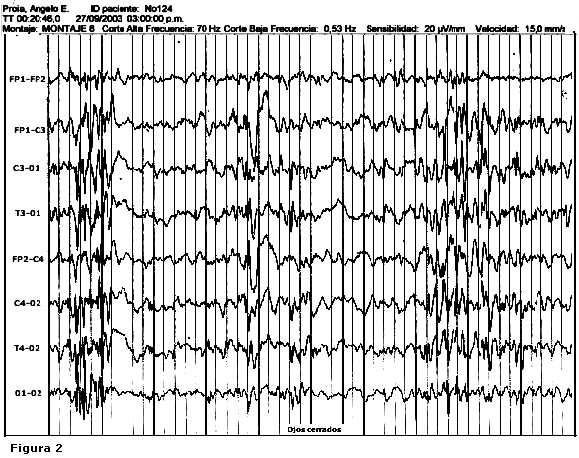

In [ ]:
import pandas as pd
import numpy as np
import random # pasado
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn
import scipy.io as sio
from scipy.signal import detrend
import os #pasado

In [ ]:
df = pd.read_csv('superemg.csv')
senal = df.iloc[:,1]
senal = senal.to_numpy()

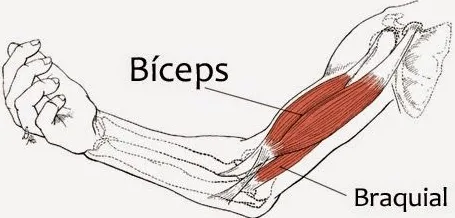

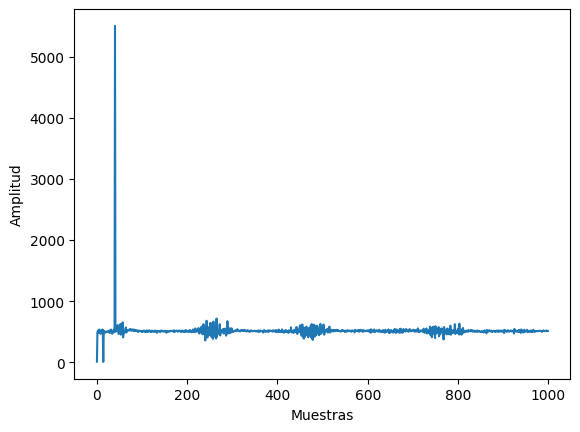

In [ ]:
plt.plot(senal)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

Eliminamos los valores que van muy por encima o por debajo de la media, reemplazandolos con el promedio.

In [ ]:
media = senal.mean()
for j,i in enumerate(senal):
  if i > media*1.5 or i < media*0.5:
    senal[j] = media

# np.ndarray no puede tener dos tipos de dato diferente - object, float, int

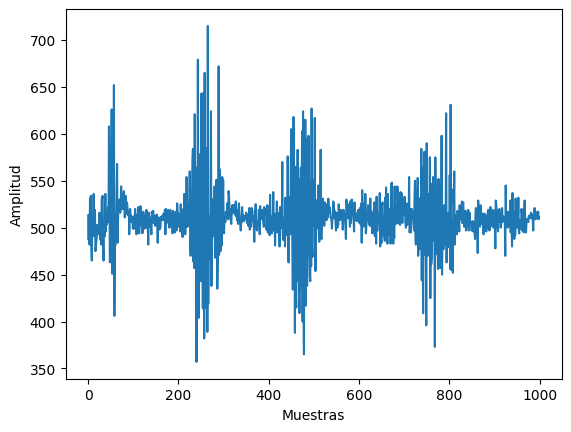

In [ ]:
plt.plot(senal)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

In [ ]:
senal.shape, senal.min(), senal.max()

((1000,), 357, 715)

In [ ]:
mu, sigma = np.mean(senal), np.std(senal)
mu, sigma

(509.439, 32.43997963932777)

In [ ]:
cv = sigma/mu*100
cv

6.367784884810108

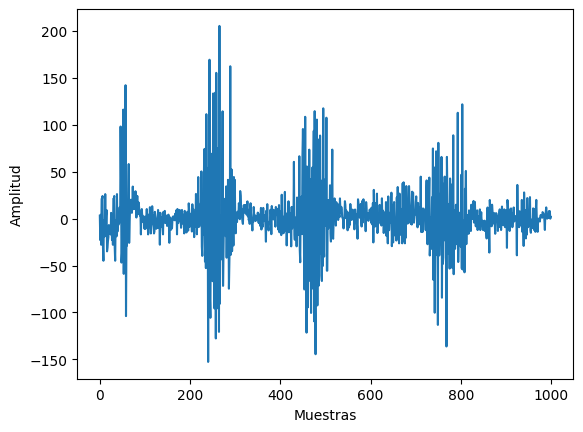

In [ ]:
senal_detrend = detrend(senal)
# y(t) = s(t) + x(t) + d
# Detecta el desfase d y la tendencia x(t)
# Las elimina
plt.plot(senal_detrend)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

In [ ]:
senal_detrend.mean(), senal_detrend.std()

(2.5266899683629164e-13, 32.43903562505652)

In [ ]:
def hampelfilter(wk: np.ndarray, K, FilterParms: list[int]) -> np.ndarray:
    """
    Procedure to implement the Hampel filter
    """
    #
    Thresh = FilterParms[0]
    ctr = wk#[K]
    ref = np.median(wk)

    AbsDev = abs(wk - ref)
    MAD = 1.4826 * np.median(AbsDev)
    TestVal = abs(ctr - ref)
    #if TestVal > Thresh * MAD:
    yk = ctr

    numero = np.sum((TestVal > Thresh * MAD)==True)

    yk[TestVal > Thresh * MAD] = ref


    return yk

def hampelFilter(archivos_ts: list[pd.DataFrame]) -> list[pd.DataFrame]:
    '''
        De los archivos anteriormente extraidos se extraerán las señales y se les
        realizara una rutina hampel para quitar los datos atipicos, posteriormente
        se retornara una lista con las columnas ya filtradas.
    '''
    archivos_procesados = []
    for columnas_extraidas in archivos_ts:
        columnas_procesadas = []
        for i in range(columnas_extraidas.shape[1]):
            if i == 0:
                columnas_procesadas.append(columnas_extraidas[i])
                continue # Nuevamente ignoraremos el tiempo.
            columna_filtrada = hampelfilter(columnas_extraidas[i], 3, [6])
            columnas_procesadas.append(columna_filtrada)
        columnas_procesadas = pd.DataFrame(list(zip(*columnas_procesadas)), columns = ['Elapsed Time (sec)',
                                                                                       'Left Stride Interval (sec)',
                                                                                       'Right Stride Interval (sec)',
                                                                                       'Left Swing Interval (sec)',
                                                                                       'Right Swing Interval (sec)'])
        archivos_procesados.append(columnas_procesadas)
    return archivos_procesados

In [ ]:
# Funcion para extraer la información
def dataExtractor(folder_path: str) -> tuple[list[pd.DataFrame], pd.DataFrame]:
    '''
    Extrae las primeras 5 señales como señales de interes para cada archivo .ts de una carpeta dada
    Además de extraerlas, sin sus 20 segundos iniciales, realiza un detrend en todas las columnas
    de interés excepto la columna 0 ya que esta es únicamente el tiempo transcurrido. Tambien realiza el filtro
    hampfel.

    Retorna dos datos, ambas listas de dataframe, uno con los datos con detrend y el otro sin detrend.
    '''
    dataE = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.ts'):
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path, sep='\s+', header=None)
            senalesinteres = data.iloc[:, [1, 2, 3, 4]]
            detrended_columns = detrend(senalesinteres, axis=0, type='linear')
            detrended_columns = pd.concat([data.iloc[:, 0],pd.DataFrame(detrended_columns, columns=[1, 2, 3, 4])], axis=1)
            senalesinteres[0] = data.iloc[:,0]*0
            senalesinteres = detrended_columns + senalesinteres.mean()
            dataE.append(senalesinteres)

    dataE = hampelFilter(dataE)
    return dataE

In [ ]:
data1, data2 = dataExtractor('/content')

<ipython-input-189-ec3cfcbeb559>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senalesinteres[0] = data.iloc[:,0]*0
<ipython-input-189-ec3cfcbeb559>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senalesinteres[0] = data.iloc[:,0]*0


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


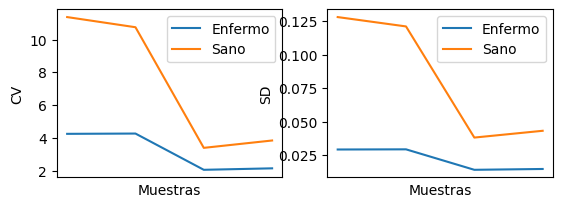

In [ ]:
def statisticExtraction(senal: np.ndarray) -> tuple[float, float]:
    '''
    Recibe una señal en forma de np.array y retorna los
    estadisticos de desviacion estandar y coeficiente de
    variacion en forma de tupla.
    Retorna dos valores.
    '''
    senal = senal.iloc[:, 1:]
    media = np.abs(np.mean(senal))
    SD = np.std(senal)
    CV = (SD/media)*100
    return (CV, SD)

cv1, sd1 = statisticExtraction(data1)
cv2, sd2 = statisticExtraction(data2)
plt.subplot(2,2,1)
plt.plot(cv1)
plt.plot(cv2)
plt.xlabel('Muestras')
plt.ylabel('CV')
plt.xticks([])
plt.legend(['Enfermo', 'Sano'])
plt.subplot(2,2,2)
plt.plot(sd1)
plt.plot(sd2)
plt.xlabel('Muestras')
plt.ylabel('SD')
plt.xticks([])
plt.legend(['Enfermo', 'Sano'])
plt.show()

In [ ]:
enfermo = sio.loadmat('enfermo.mat')
sano = sio.loadmat('sano.mat')
enfermo, sano = enfermo['data'], sano['data']

In [ ]:
enfermo.shape, sano.shape

((8, 2000, 174), (8, 2000, 187))

Hay que unir todas las épocas
(canales, señal, épocas) - No tocar la señal
Juntar las señales y épocas en un solo arreglo

por cada canal ustedes tendrán señal*epocas de datos. Convertir una señal tridimensional a una señal de dos dimensiones.

In [ ]:
enfermoReshaped = enfermo.reshape(enfermo.shape[0], -1)
sanoReshaped = sano.reshape(sano.shape[0], -1)

In [ ]:
enfermo.shape # (canales = 8, senal en el tiempo = 2000, epocas = 174)
# Primero hagan el recorte para elegir cuales canales y cuantas y cuales epocas van a graficar
# Juntan todas las señales en el tiempo de un mismo canal
# (2 al 6, senal, 50 al 100) (4, 2000, 50)
# (4, 2000*50)

(8, 2000, 174)

### **Ejercicio 1**
Crear una clase que reciba una señal completa y sea capaz de graficar de ella todos sus canales, además extraer datos estadisticos de cada uno.

In [ ]:
class Graficas: # Esta recibiendo la señal ya procesada
  def __init__(self, senal):
    self.senal = senal
    self.canales = []
    self.estadisticas = pd.DataFrame(columns = ['SD', 'CV'])
    self.fig, self.ax = plt.subplots() # Creo una figura para graficar en el objeto

  def separarCanales(self):
    for i in range(self.senal.shape[0]):
      self.canales.append(self.senal[i,:])

  def plotCanales(self):
    for i in range(len(self.canales)):
      self.ax.plot(self.canales[i] + i*35)
    self.ax.set_xlabel('Muestras')
    self.ax.set_ylabel('Amplitud')
    plt.show()

  def hist(self): # Para una grafica unica
    self.ax.hist(self.senal, bins = 50)
    self.ax.set_xlabel('Amplitud')
    self.ax.set_ylabel('Frecuencia')
    plt.show()

  def boxplot(self): #para una grafica unica
    self.ax.boxplot(self.senal)
    plt.show()

  def statisticExtraction(self) -> pd.DataFrame:
    pass

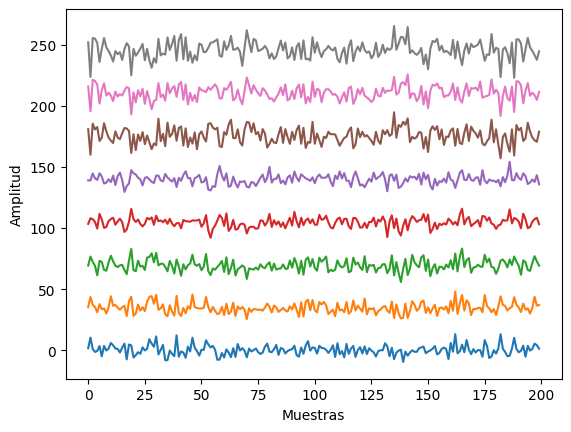

In [ ]:
graficador = Graficas(sanoReshaped[:,:200])
graficador.separarCanales()
graficador.plotCanales()
graficador.statisticExtraction()

In [ ]:
df55 = pd.DataFrame(columns = ['t', 't'])
df55.loc['a'] = [1,2]
df55.loc['b'] = [3,4]
df55.loc['c'] = [5,6]
df55

,t,t
a,1,2
b,3,4
c,5,6


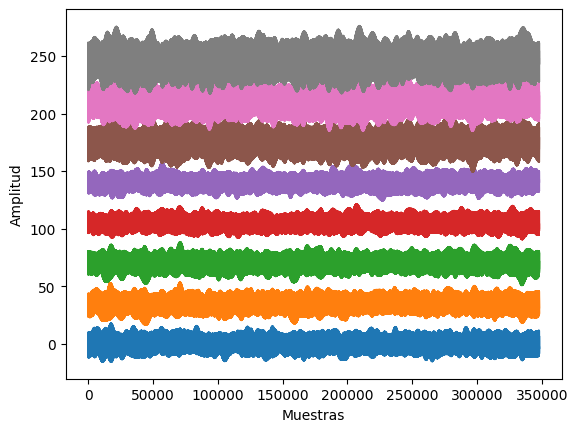

,SD,CV
0,20537.116597,3.834156
1,29822.855262,3.950585
2,26266.948549,3.915580
3,37243.430366,3.514055
4,32830.546941,3.556432
5,16761.574500,5.829181
6,18195.584892,6.118166
7,19048.226143,7.194428


In [ ]:
graficador = Graficas(enfermoReshaped)
graficador.separarCanales()
graficador.plotCanales()
graficador.statisticExtraction()

In [ ]:
estadisticas.SD >= estadisticas.SD.mean()

,SD
0,False
1,True
2,True
3,True
4,True
5,False
6,False
7,False


In [ ]:
estadisticas = graficador.statisticExtraction()
estadisticas[estadisticas.SD < estadisticas.SD.mean()]

AttributeError: 'NoneType' object has no attribute 'SD'

### **Ejercicio 2**
Crear una clase que pueda graficar multiples señales al mismo tiempo en subplots

In [ ]:
class GraficasMultiples:
  def __init__(self, senales: list [np.ndarray], n: int = 1, m: int = 1):
    self.senales = senales
    self.fig, self.ax = plt.subplots(n, m, sharex= True, sharey= True)
    self.n = n
    self.m = m
    if len(senales) > n*m:
      print('El numero de señales es mayor al numero de subplots\nConsidere cambiar el numero de subplots')

  def changeNM(self,n:int, m:int):
    self.n = n
    self.m = m
    self.fig, self.ax = plt.subplots(n, m, sharex= True, sharey= True)
    if len(self.senales) > self.n*self.m:
      print('El numero de señales es mayor al numero de subplots\nConsidere cambiar el numero de subplots')

  def autoPlot(self):
    k = 0
    for i in range(self.n):
      for j in range(self.m):
        if len(self.senales)-1 < k:
          continue
        if self.n == 1 and self.m == 1: # Un espacio
          self.ax.plot(self.senales[k])
        elif self.n == 1 or self.m == 1: # 1xA
          self.ax[j].plot(self.senales[k])
        else:
          self.ax[i,j].plot(self.senales[k])
        k+=1

  def autoHist(self):
    k = 0
    for i in range(self.n):
      for j in range(self.m):
        if len(self.senales)-1 < k:
          continue
        if self.n == 1 and self.m == 1:
          self.ax.hist(self.senales[k], bins = 50)
        elif self.n == 1 or self.m == 1:
          self.ax[j].hist(self.senales[k], bins = 50)
        else:
          self.ax[i,j].hist(self.senales[k], bins = 50)
        k+=1

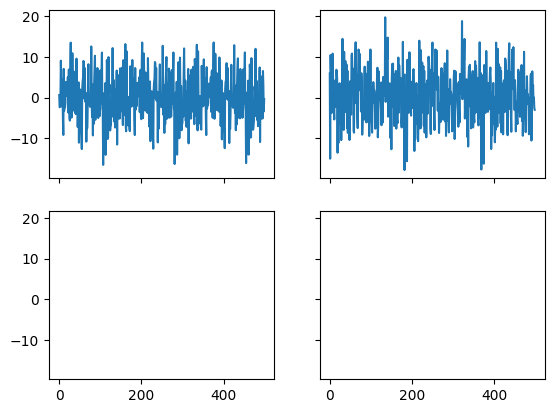

In [ ]:
GMultiples = GraficasMultiples([enfermoReshaped[5,0:500], sanoReshaped[5,0:500]], 2, 2)
GMultiples.autoPlot()

El numero de señales es mayor al numero de subplots
Considere cambiar el numero de subplots


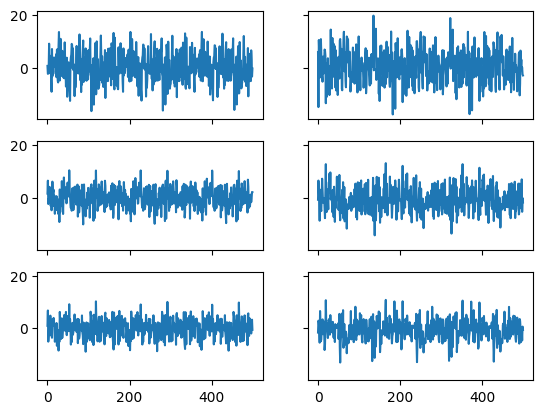

In [ ]:
GMultiples.changeNM(3,2)
GMultiples.senales += [enfermoReshaped[2,0:500], sanoReshaped[2,0:500], enfermoReshaped[3,0:500], sanoReshaped[3,0:500]]
GMultiples.autoPlot()

El numero de señales es mayor al numero de subplots
Considere cambiar el numero de subplots


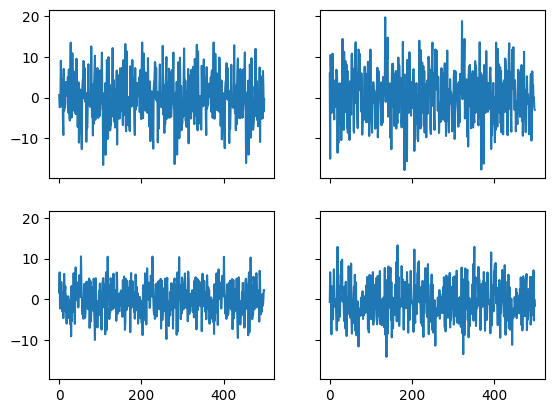

In [ ]:
GMultiples.changeNM(2,2)
GMultiples.autoPlot()

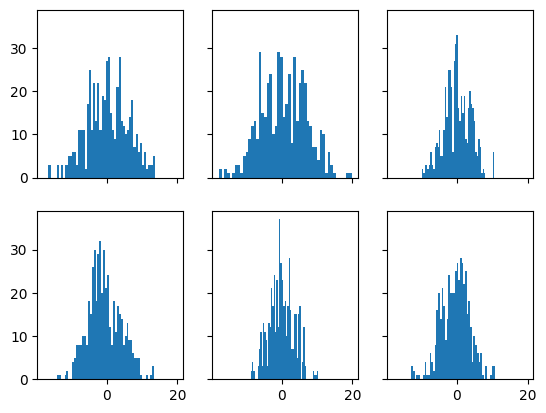

In [ ]:
GMultiples.changeNM(2,3)
GMultiples.autoHist()


### **Ejercicio 3**
1. Crear una suma de funciones senoidales aleatorias, con amplitudes y frecuencias diferentes.
2. Crear de manera similar una suma de funciones cuadradas (t<a = -1, t>a = 1).
3. A la señal creada anteriormente aplicar un promedio movil de una ventana de 5.

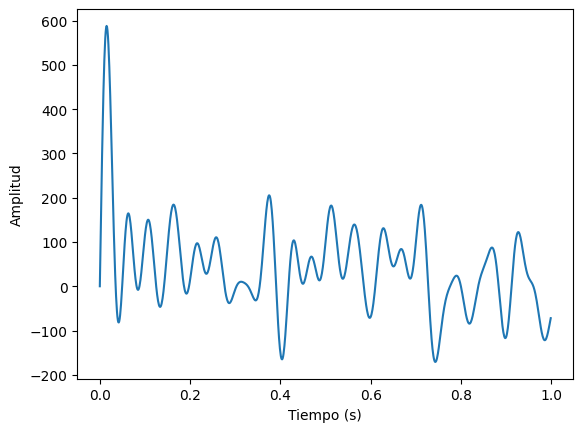

In [ ]:
t = np.linspace(0, 1, 1000, endpoint=False) # Vector de tiempos
nums = [(i,j) for i in np.random.uniform(0, 25, 8) for j in np.random.uniform(0, 25, 8)] # Creando numeros aleatorios
senoidal = np.zeros(len(t))
for num in nums:
  senoidal += num[0] * np.sin(2 * np.pi * num[1] * t) # Suma de senoidales
plt.plot(t, senoidal)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

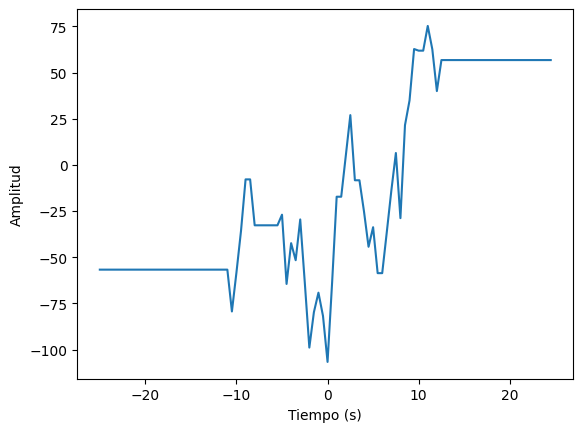

In [ ]:
# Ahora creo una suma de funciones cuadradas
t = np.linspace(-25, 25, 100, endpoint=False)
nums = [(i,j) for i in np.random.uniform(-12.5, 12.5, 8) for j in np.random.uniform(-12.5, 12.5, 8)]
lin = np.zeros(len(t))
for num in nums:
  lin += num[0] * np.where(t < num[1], -1, 1)
plt.plot(t, lin)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

In [ ]:
df = pd.DataFrame({'Tiempo': t, 'Valor': lin})
df.head()

,Tiempo,Valor
0,-25.0,-56.741864
1,-24.5,-56.741864
2,-24.0,-56.741864
3,-23.5,-56.741864
4,-23.0,-56.741864


In [ ]:
df['Rolled'] = df['Valor'].rolling(window=5).mean()
df.head(10)

,Tiempo,Valor,Rolled
0,-25.0,-56.741864,NaN
1,-24.5,-56.741864,NaN
2,-24.0,-56.741864,NaN
3,-23.5,-56.741864,NaN
4,-23.0,-56.741864,-56.741864
5,-22.5,-56.741864,-56.741864
6,-22.0,-56.741864,-56.741864
7,-21.5,-56.741864,-56.741864
8,-21.0,-56.741864,-56.741864
9,-20.5,-56.741864,-56.741864


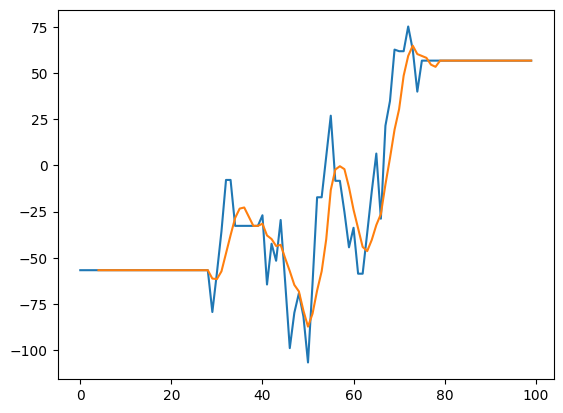

In [ ]:
df['Valor'].plot()
df['Rolled'].plot()
plt.show()

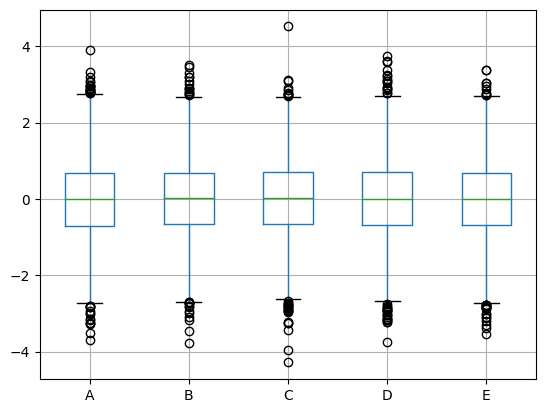

In [ ]:
df = pd.DataFrame(np.random.randn(5000, 5), columns=['A', 'B', 'C', 'D', 'E'])
df.boxplot()
plt.show()

In [ ]:
df.head()

,A,B,C,D,E
0,1.615117,-0.224900,-0.377848,0.346119,-1.773458
1,0.175663,-0.624970,-0.251603,0.567460,-0.278138
2,-1.377801,0.753355,1.001469,1.176480,1.513763
3,1.150678,-1.128050,-0.699622,-1.800015,0.963588
4,0.482034,-0.180759,3.510093,-1.350976,1.365713
